I0000 00:00:1758646000.747256  455418 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1758646000.747388  455418 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 4.3952 - mae: 1.6346 - val_loss: 0.5440 - val_mae: 0.7226
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.7481 - mae: 0.6928 - val_loss: 0.5756 - val_mae: 0.7443
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6235 - mae: 0.6360 - val_loss: 0.4789 - val_mae: 0.6789
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5649 - mae: 0.5955 - val_loss: 0.4567 - val_mae: 0.6622
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4769 - mae: 0.5300 - val_loss: 0.4695 - val_mae: 0.6707
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4110 - mae: 0.5081 - val_loss: 0.4577 - val_mae: 0.6606
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3387 - mae: 0.4560 - val_loss: 0.4147 - val_mae: 0.6239
Epoch 8/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2554 - mae: 0.3959 - val_loss: 0.4618 - val_mae: 0.6461
Epoch 9/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.18

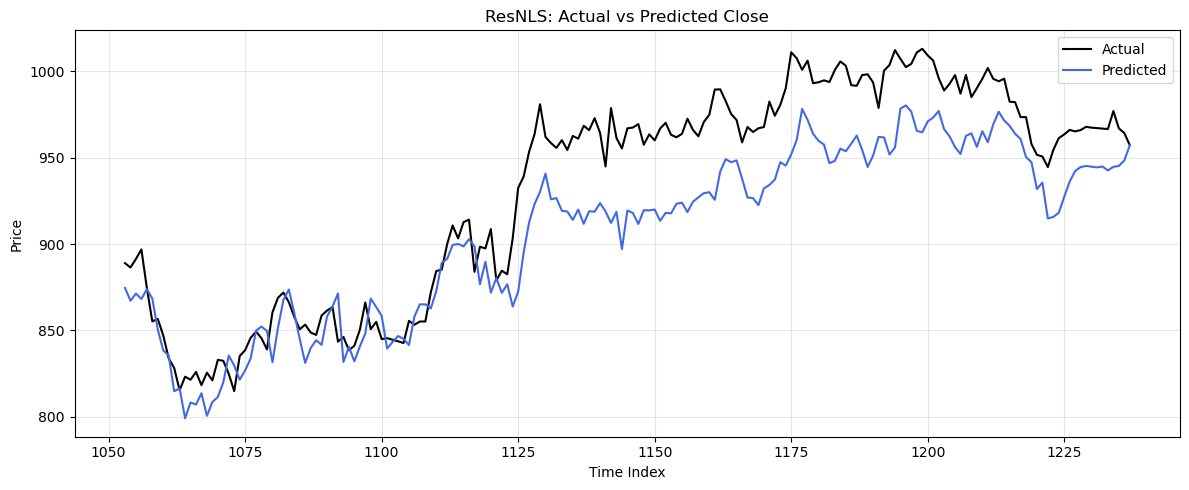

In [2]:
# notebooks/ResNLS_notebook.py
# Standalone ResNLS model: load CSV, build sequences, train, and plot Actual vs Pred
import os, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import layers, Model

# -----------------------------
# Config
# -----------------------------
# DATA_CSV = "data/HDFCBANK.NS.csv"  # change to desired CSV
TARGET = "Close"                   # predict next close
SEQ_LEN = 5                        # short window for local patterns (ResNLS)
VAL_FRAC = 0.15
TEST_FRAC = 0.15
RANDOM_SEED = 42

data_dir = "../Data"  # path where your CSVs are stored
ticker = 'HDFCBANK.NS'
DATA_CSV = os.path.join(data_dir, f"{ticker}_features.csv")

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# -----------------------------
# Optional indicators (pure-python)
# -----------------------------
def ema(series: pd.Series, span: int) -> pd.Series:
    k = 2 / (span + 1)
    return series.ewm(alpha=k, adjust=False).mean()

def wilder_ema(series: pd.Series, period: int) -> pd.Series:
    return series.ewm(alpha=1/period, adjust=False).mean()

def rsi_wilder(close: pd.Series, period: int = 14) -> pd.Series:
    delta = close.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    avg_up = wilder_ema(up, period)
    avg_down = wilder_ema(down, period)
    rs = avg_up / (avg_down.replace(0, np.nan))
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(0)

def macd(close: pd.Series, fast=12, slow=26, signal=9):
    ema_fast = ema(close, fast)
    ema_slow = ema(close, slow)
    macd_line = ema_fast - ema_slow
    signal_line = ema(macd_line, signal)
    hist = macd_line - signal_line
    return macd_line, signal_line, hist

def atr_wilder(high: pd.Series, low: pd.Series, close: pd.Series, period: int = 14) -> pd.Series:
    prev_close = close.shift(1)
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return wilder_ema(tr, period)

# -----------------------------
# Load data
# -----------------------------
df = pd.read_csv(DATA_CSV)
# Standardize column names if needed
cols = {c: c.title() for c in df.columns}
df.rename(columns=cols, inplace=True)
df = df[['Open','High','Low','Close','Volume']].dropna().reset_index(drop=True)

# Build a modest feature set
features = df.copy()
features['LogRet'] = np.log(features['Close']).diff().fillna(0.0)
features['RSI14'] = rsi_wilder(features['Close'], 14)
m, s, h = macd(features['Close'])
features['MACD'] = m
features['MACD_SIGNAL'] = s
features['ATR14'] = atr_wilder(features['High'], features['Low'], features['Close'], 14)
features = features.dropna().reset_index(drop=True)

# Target: next-step Close
target = features[TARGET].shift(-1).dropna().reset_index(drop=True)
features = features.iloc[:-1, :].reset_index(drop=True)

# -----------------------------
# Train/Val/Test chronological split
# -----------------------------
n = len(features)
test_size = int(math.floor(TEST_FRAC * n))
val_size = int(math.floor(VAL_FRAC * n))
train_size = n - val_size - test_size

X_all = features.values
y_all = target.values.reshape(-1, 1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_raw = X_all[:train_size]
X_val_raw   = X_all[train_size:train_size+val_size]
X_test_raw  = X_all[train_size+val_size:]

y_train_raw = y_all[:train_size]
y_val_raw   = y_all[train_size:train_size+val_size]
y_test_raw  = y_all[train_size+val_size:]

X_train_s = scaler_X.fit_transform(X_train_raw)
X_val_s   = scaler_X.transform(X_val_raw)
X_test_s  = scaler_X.transform(X_test_raw)

y_train_s = scaler_y.fit_transform(y_train_raw)
y_val_s   = scaler_y.transform(y_val_raw)
y_test_s  = scaler_y.transform(y_test_raw)

def make_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len + 1):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len-1])
    return np.array(Xs), np.array(ys)

Xtr, ytr = make_sequences(X_train_s, y_train_s, SEQ_LEN)
Xva, yva = make_sequences(np.vstack([X_train_s[-(SEQ_LEN-1):], X_val_s]), 
                          np.vstack([y_train_s[-(SEQ_LEN-1):], y_val_s]), SEQ_LEN)
Xte, yte = make_sequences(np.vstack([X_val_s[-(SEQ_LEN-1):], X_test_s]), 
                          np.vstack([y_val_s[-(SEQ_LEN-1):], y_test_s]), SEQ_LEN)

# Index alignment for plotting on original test segment
test_plot_index = np.arange(train_size + val_size, train_size + val_size + len(yte))

# -----------------------------
# ResNLS model
# -----------------------------
def res_block(x, filters, k=3):
    sc = x
    x = layers.Conv1D(filters, k, padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(filters, k, padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    if sc.shape[-1] != filters:
        sc = layers.Conv1D(filters, 1, padding='same', activation=None)(sc)
    x = layers.Add()([x, sc])
    x = layers.Activation('relu')(x)
    return x

inp = layers.Input(shape=(SEQ_LEN, Xtr.shape[-1]))
# Res pathway
r = layers.Conv1D(32, 3, padding='same', activation='relu')(inp)
r = res_block(r, 32)
r = res_block(r, 64)
r_feat = layers.GlobalMaxPooling1D()(r)
# LSTM pathway
lstm_out = layers.LSTM(64, return_sequences=False)(inp)
# Merge
merged = layers.Concatenate()([r_feat, lstm_out])
h = layers.Dense(64, activation='relu')(merged)
h = layers.Dropout(0.2)(h)
embedding = layers.Dense(64, activation='relu', name='resnls_embedding')(h)
out = layers.Dense(1, activation='linear')(embedding)
model = Model(inp, out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])

cbs = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]
hist = model.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=60, batch_size=64, callbacks=cbs, verbose=1)

# -----------------------------
# Evaluate and plot
# -----------------------------
y_pred_s = model.predict(Xte, batch_size=256)
y_pred = scaler_y.inverse_transform(y_pred_s)
y_true = scaler_y.inverse_transform(yte)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = math.sqrt(mse)
print(f"MSE={mse:.6f}  RMSE={rmse:.6f}  MAE={mae:.6f}")

plt.figure(figsize=(12,5))
plt.plot(test_plot_index, y_true.flatten(), label="Actual", color='black', linewidth=1.5)
plt.plot(test_plot_index, y_pred.flatten(), label="Predicted", color='royalblue', linewidth=1.5)
plt.title("ResNLS: Actual vs Predicted Close")
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
